In [ ]:
import pandas as pd

In [ ]:
polygon_pt_counts = pd.Series([1840, 1618, 1646, 1464, 1658, 1564, 1600, 1814, 1652, 1592, 1748, 1754, 1636, 1730,
                              1650, 1666, 1752, 2158, 1992, 1758, 1798])

In [ ]:
polygon_pt_counts.describe()

In [ ]:
import csv

In [ ]:
points_divided_df = pd.read_csv("../points_in_polys_validation.csv")

In [ ]:
# PNTCNT is a unique identifier!
points_in_polys = {poly: points_divided_df[points_divided_df['PNTCNT'] == poly] 
                  for poly in points_divided_df['PNTCNT'].unique()}

In [ ]:
samples = {poly: points_in_polys[poly].sample(n=10) for poly in points_in_polys}

In [ ]:
samples = {poly: samples[poly][['x','y']] for poly in points_in_polys}

In [ ]:
samples[1600]['y'][1229]

In [ ]:
import glob
import shutil
import random
for poly in samples:
    for _, sample in samples[poly].iterrows():
        # want to get rid of rounding error when these were truncated
        # but leave enough digits to find the photo
        for i in range(10):
            y = str(sample['y'])[:-i]
            matches = glob.glob("../data/streetphotos/42/" + y + "*")
            if len(matches) != 2:
                continue
            else:
                break

        if len(matches) != 2:
            print(sample)
            continue
        # choose left or right at random
        
        match = random.choice(matches)
        match_name = match.split('/')[-1]
        shutil.copyfile(match, "../data/streetphotos/validation_sample/" + match_name)
        
        

In [ ]:
validation_df = pd.read_csv("../data/streetphotos/validation_sample/validation_hand.csv", names=["label"])

In [ ]:
validation_df.describe()

In [ ]:
import os.path

In [ ]:
sorted(list(os.walk("../data/streetphotos/validation_sample/"))[0][2])

In [ ]:
hand_predictions = {}
for file, pred in zip(sorted(list(os.walk("../data/streetphotos/validation_sample/"))[0][2])[:-1], validation_df['label']):
    hand_predictions[file] = pred

In [ ]:
hand_predictions_df = pd.DataFrame.from_dict(hand_predictions, orient='index').reset_index()
hand_predictions_df['x'] = hand_predictions_df['index'].str.split(',').map(lambda x : float(x[0]))
hand_predictions_df['direction'] = hand_predictions_df['index'].str.split('_').map(lambda x : x[-1][:-4])
hand_predictions_df = hand_predictions_df[['x',0, 'direction']].set_index('x')

In [ ]:
import pickle as pkl
with open("../data/streetphotos/all_pts_2_low_gamma.pkl", 'rb') as pklfile:
    all_pts_2_low_gamma = pkl.load(pklfile)
    
with open("../data/streetphotos/all_pts_1_low_gamma.pkl", 'rb') as pklfile:
    all_pts_1_low_gamma = pkl.load(pklfile)
    

In [ ]:
all_pts_2_low_gamma['x'] = all_pts_2_low_gamma['point'].map(lambda x : x[1])
all_pts_1_low_gamma['x'] = all_pts_1_low_gamma['point'].map(lambda x : x[1])

In [ ]:
all_pts_2_low_gamma = all_pts_2_low_gamma[['direction','x']].set_index('x')
all_pts_1_low_gamma = all_pts_1_low_gamma[['direction', 'x']].set_index('x')

In [ ]:
maybe_1_low_gamma = hand_predictions_df.join(all_pts_1_low_gamma, how='inner', lsuffix="hand", rsuffix="cnn")
maybe_2_low_gamma = hand_predictions_df.join(all_pts_2_low_gamma, how='inner', lsuffix="hand", rsuffix="cnn")

In [ ]:
len(hand_predictions_df[hand_predictions_df[0].isin(['s','o'])]), len(hand_predictions_df[hand_predictions_df[0].isin(['n'])]),len(hand_predictions_df[hand_predictions_df[0].isin(['nn'])])

In [ ]:
len(hand_predictions_df[hand_predictions_df[0].isin(['s','o'])]), len(hand_predictions_df[hand_predictions_df[0].isin(['n'])])

In [ ]:
len(maybe_1_low_gamma[maybe_1_low_gamma[0].isin(['s','o']) & (maybe_1_low_gamma['directioncnn'] == maybe_1_low_gamma['directionhand'])])

In [ ]:
len(maybe_1_low_gamma[maybe_1_low_gamma[0].isin(['n']) & (maybe_1_low_gamma['directioncnn'] == maybe_1_low_gamma['directionhand'])])

## For `maybe_1`

- the positive class has 38 members `len(hand_predictions_df[hand_predictions_df[0].isin(['s','o'])]`
- the negative class has 77 members `len(hand_predictions_df[hand_predictions_df[0].isin(['n'])])`
- 85 nulls `200 - 38 - 77`

Of the positive class

- 24 are correctly detected `len(maybe_1[maybe_1[0].isin(['s','o']) & (maybe_1['directioncnn'] == maybe_1['directionhand'])])`
- 14 are not `38 - 10`

Of the negative class
- 57 correctly detected
- 20 false positives `len(maybe_1[maybe_1[0].isin(['n']) & (maybe_1['directioncnn'] == maybe_1['directionhand'])])`

Recall: 63%
Precision: 54%

## For `maybe_2`
If we believe that this join is correct:

- the positive class has 39 members `len(maybe[maybe[0].isin(['s','o'])])`
- the actual negative class has 77 members `len(maybe[maybe[0] == 'n']`
- the remaining null photos have 85 members `len(maybe[maybe[0] == 'nn'])`

Of the positive class:
- 8 are correctly detected
- 31 are not

Of the negative class:
- 31 false positives `len(maybe[(pd.isnull(maybe['direction'])) & (maybe[0] != 'nn') & (maybe[0].isin(['s','o']))])`
- 46 correct

This gives us precision and recall of 21%.

Overall we see that the positive rate is `39/(39 + 77) * 100` or 33 percent.  The null rate is `1 - 22558/34294`, i.e. 34.2 percent.  

Precision: P(Pos | PosLabel). THIS DOES NOT CHANGE because we are conditioning on a positive label.

Recall: P(PosLabel | Pos) = P(PosLabel | Pos, NotNull)P(NotNull) + P(PosLabel | Pos, Null)P(Null)

P(PosLabel | Null) is zero, so

Recall = P(PosLabel | Pos, NotNull)P(NotNull) = 14%



In [ ]:
len(all_pts_1)

In [2]:
import seaborn as sms
import matplotlib.pyplot as plt 

In [3]:
array = [[24,14],[20,57]]

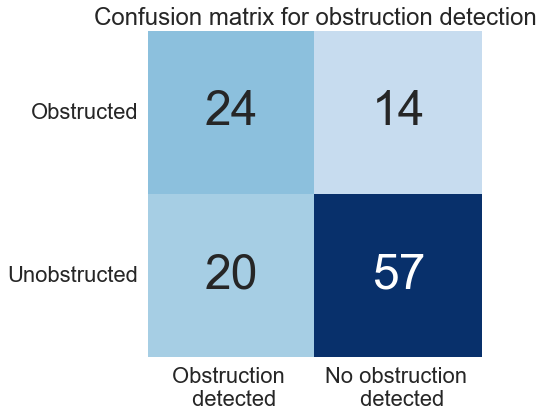

In [23]:
from matplotlib import pyplot
pyplot.figure(figsize=(6, 6))
sms.set(font_scale = 2)

ax = sms.heatmap(array, 
            annot=True, 
            cbar=False, 
            cmap="Blues", 
            #yticklabels = ["Obstructed", "Unobstructed"],
            xticklabels = ["Obstruction \n detected", "No obstruction \n detected"],
            vmin=0, vmax=57, 
            annot_kws={'size':48, 
                       'name':'Arial'
                       }
           )
#ax.figure.axes[-1].yaxis.label.set_size(64)
ax.set_yticklabels(['Obstructed', 'Unobstructed'], va='center', rotation = 0, position=(0,0.28))
plt.title('Confusion matrix for obstruction detection')
plt.savefig('confusion_matrix.png',
           dpi=450, quality=95, bbox_inches='tight')